In [1]:
#importaciones
from IPython.display import HTML
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import _converter
plt.subplots(figsize=(15,4))
%matplotlib inline 
plt.style.use('default')
import datetime
import math
sns.set(style="whitegrid") # seteando tipo de grid en seaborn

In [2]:
# Leyendo csvs
df_edu = pd.read_csv("../datos_navent_fiuba/fiuba_1_postulantes_educacion.csv")
df_gen_edad = pd.read_csv("../datos_navent_fiuba/fiuba_2_postulantes_genero_y_edad.csv", parse_dates=['fechanacimiento'])
df_vistas = pd.read_csv("../datos_navent_fiuba/fiuba_3_vistas.csv", parse_dates=['timestamp'])
df_postulaciones = pd.read_csv("../datos_navent_fiuba/fiuba_4_postulaciones.csv", parse_dates=['fechapostulacion'])
df_avisos_detalle = pd.read_csv("../datos_navent_fiuba/fiuba_6_avisos_detalle.csv")


# ¿Cuáles areas tienen mayor postulaciones por nivel educativo?

In [3]:
orden_nombre = {
    "Doctorado":0,
    "Master":1,
    "Posgrado":2,
    "Universitario":3,
    "Terciario/Técnico":4,
    "Secundario":5,
    "Otro":6
}

orden_estado = {
    "Graduado":0,
    "En Curso":1,
    "Abandonado":2,
}

df_edu["prioridad_nom"] = df_edu["nombre"].apply(lambda nombre: orden_nombre.get(nombre))
df_edu["prioridad_est"] = df_edu["estado"].apply(lambda estado: orden_estado.get(estado))

df_edu.sort_values(by= ["idpostulante","prioridad_est","prioridad_nom"],inplace= True)

df_edu_unicos_max = df_edu.drop_duplicates(subset = "idpostulante",keep= "first")

df_edu_max_postulaciones = df_edu_unicos_max.merge(df_postulaciones, on = "idpostulante")

df_aviso_corto = df_avisos_detalle[["idaviso","tipo_de_trabajo","nivel_laboral","nombre_area"]]

df_max_post_detalle = df_edu_max_postulaciones.merge(df_aviso_corto, on = "idaviso")

In [4]:
def top_n_areas_graduados(n, educacion):
    top_10_areas_graduados_secundario = df_max_post_detalle[(df_max_post_detalle["nombre"] == educacion) & (df_max_post_detalle["estado"] == "Graduado")] \
                                        .groupby("nombre_area")['idpostulante']\
                                        .count() \
                                        .sort_values(ascending=False) \
                                        .head(n)

    g = sns.barplot(x=top_10_areas_graduados_secundario.values, y=top_10_areas_graduados_secundario.index, orient='h', palette="hls")
    g.set_title("Postulantes graduados de nivel {0} por area".format(educacion.lower()), fontsize=18)
    g.set_xlabel("Cantidad de graduados", fontsize=12)
    g.set_ylabel("Nombre del Area", fontsize=12)
    plt.subplots_adjust(top=0.9)

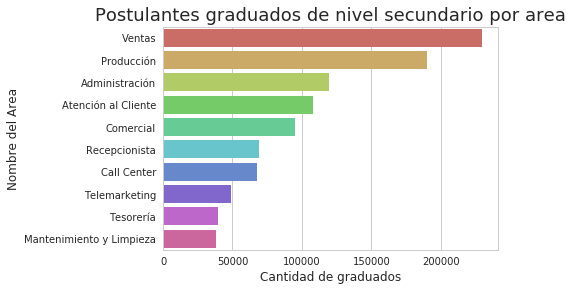

In [5]:
top_n_areas_graduados(10, "Secundario")    

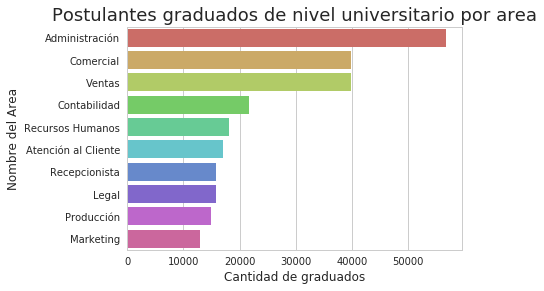

In [6]:
top_n_areas_graduados(10, "Universitario")

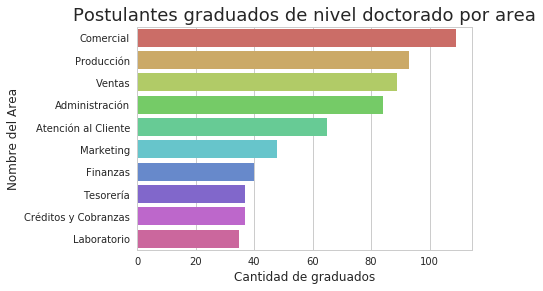

In [7]:
top_n_areas_graduados(10, "Doctorado")

# ¿Cómo se distribuye la edad en los distintos niveles educativos?

In [8]:
# limpieza de fechas invalidas
df_gen_edad["fechanacimiento"] = pd.to_datetime(df_gen_edad["fechanacimiento"], errors="coerce")

def calc_edad(x):    
    if (pd.isnull(x)):
        return -1
    return math.floor((datetime.datetime.today()-x).days / 365)

# calculo edad para cada postulante
df_gen_edad["edad"] = df_gen_edad["fechanacimiento"].apply(calc_edad)

In [9]:
df_edu_unicos_con_edad = df_edu_unicos_max.loc[df_edu_unicos_max['estado'] == 'Graduado']\
                                          .merge(df_gen_edad, on='idpostulante')

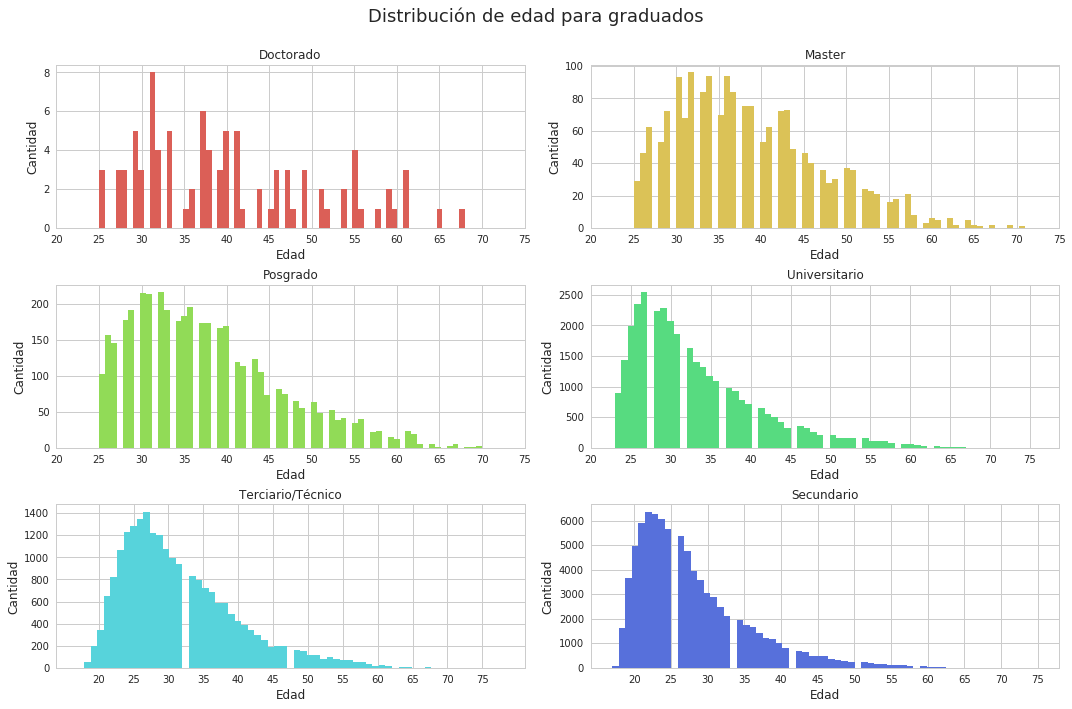

In [10]:
df_edu_unicos_con_edad = df_edu_unicos_con_edad.loc[df_edu_unicos_con_edad['edad'] > 0]
    
fig, axes = plt.subplots(3, 2, figsize=(15,10))

fig.suptitle("Distribución de edad para graduados", fontsize=18)

nombres = list(orden_nombre.keys())

# no parece coherente que haya personas de 20 años con doctorado, por lo 
# que vamos a fijar edades minimas esperadas
edad_minima_nivel_educativo = {
    "Doctorado": 25,
    "Master": 25,
    "Posgrado": 25,
    "Universitario": 23,
    "Terciario/Técnico": 0,
    "Secundario": 0,
    "Otro": 0
}

# no queremos que los casos aislados nos sesguen los gráficos
LIM_SUP_EDAD = 80

indice_nivel = 0

colores = sns.color_palette("hls", 8)

for i in range(0, 3):
    for j in range(0, 2):
        ax = axes[i][j]
        nom = nombres[indice_nivel]
        
        serie = df_edu_unicos_con_edad.groupby(['nombre']) \
                                      .get_group(nom)['edad']
            
        serie = serie.loc[(edad_minima_nivel_educativo[nom] <= serie) & (serie <= LIM_SUP_EDAD)]
        
        ticks = np.arange(20, 80, 5)
        
        ax.hist(serie, 80 - 15, color=colores[indice_nivel]) # uno para cada edad
        ax.set_title(nom)
        ax.set_xticks(ticks)
        ax.set_xlabel("Edad", fontsize=12)
        ax.set_ylabel("Cantidad", fontsize=12)
        indice_nivel += 1
    
plt.tight_layout()
plt.subplots_adjust(top=0.9)

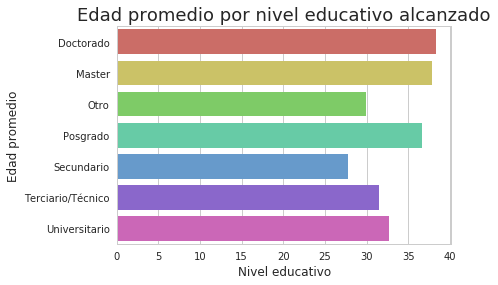

In [11]:
promedio_edad_por_educacion = df_edu_unicos_con_edad.groupby('nombre')['edad'].mean().reset_index()
g = sns.barplot(x=promedio_edad_por_educacion['edad'], y=promedio_edad_por_educacion['nombre'], orient='h', palette="hls")
g.set_title("Edad promedio por nivel educativo alcanzado", fontsize=18)
g.set_xlabel("Nivel educativo", fontsize=12)
g.set_ylabel("Edad promedio", fontsize=12);

In [12]:
del df_edu_unicos_con_edad

# ¿Qué tipo de trabajo eligen los postulantes según la educación alcanzada?

In [13]:
def top_n_tipo_trabajo_educacion(n, educacion):
    top_tipo_trabajo_universitario = df_max_post_detalle.loc[df_max_post_detalle["nombre"] == educacion]\
                                                         .groupby("tipo_de_trabajo")['idpostulante']\
                                                         .count()\
                                                         .sort_values(ascending=False)\
                                                         .head(n)

    g = sns.barplot(x=top_tipo_trabajo_universitario.values, y=top_tipo_trabajo_universitario.index, orient="h", palette="hls")    
    g.set_title("Distibucion de Tipo de trabajo en postulantes {0}".format(educacion), fontsize=18)
    g.set_xlabel("Cantidad", fontsize=12)
    g.set_ylabel("Tipo de Trabajo", fontsize=12);
    
    del top_tipo_trabajo_universitario

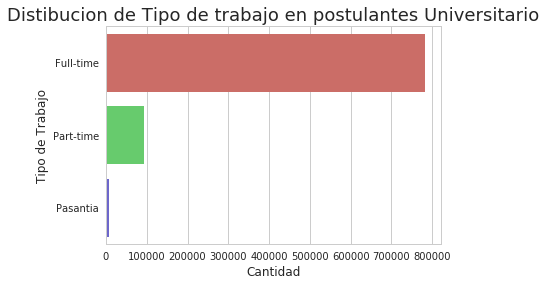

In [14]:
top_n_tipo_trabajo_educacion(3, "Universitario")

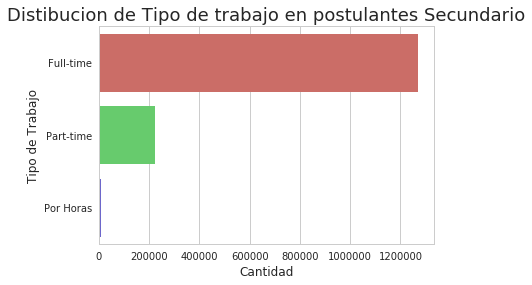

In [15]:
top_n_tipo_trabajo_educacion(3, "Secundario")

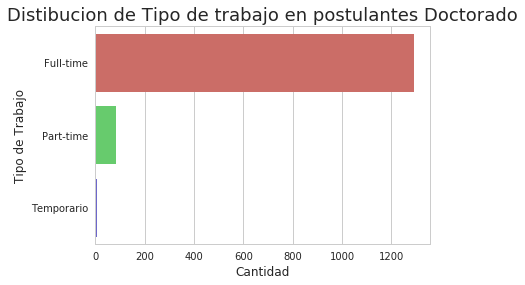

In [16]:
top_n_tipo_trabajo_educacion(3, "Doctorado")

# ¿Cómo es la distribución de edades de los postulantes por sexo?

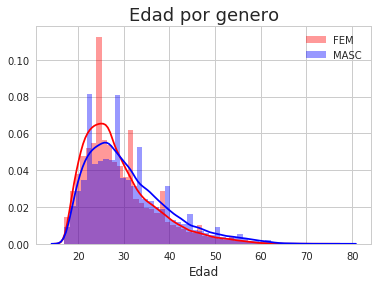

In [17]:
df_gen_edad_valida = df_gen_edad.loc[(17 <= df_gen_edad['edad']) & (df_gen_edad['edad'] <= 80)]

df_edad_fem = df_gen_edad_valida.loc[df_gen_edad_valida['sexo'] == 'FEM']
df_edad_masc = df_gen_edad_valida.loc[df_gen_edad_valida['sexo'] == 'MASC']

g = sns.distplot(df_edad_fem['edad'], color='red', label='FEM', rug=False)
g = sns.distplot(df_edad_masc['edad'], color='blue', label='MASC', rug=False)

g.set_title("Edad por genero", fontsize=18)
g.set_xlabel("Edad", fontsize=12)
g.legend();

In [18]:
del df_edad_fem
del df_edad_masc

# ¿Qué tipo de trabajo eligen los postulantes según su sexo?

In [19]:
id_gen_corto = df_gen_edad_valida[["idpostulante","sexo"]]
df_sexo_tipo_trabajo =df_max_post_detalle.merge(id_gen_corto,on= "idpostulante")[["sexo","tipo_de_trabajo"]]

In [20]:
df_fem_tipo_trabajo = df_sexo_tipo_trabajo[df_sexo_tipo_trabajo["sexo"] == "FEM"]
top3_fem_tipo_trabajo= df_fem_tipo_trabajo.groupby(["tipo_de_trabajo"])\
                      .count()\
                      .sort_values(by= "sexo",ascending=False)\
                      .head(2)
total= float(top3_fem_tipo_trabajo.sum())
top3_fem_tipo_trabajo["porcentaje"] = top3_fem_tipo_trabajo["sexo"].apply(lambda x: round(x/total*100))

In [21]:
df_masc_tipo_trabajo = df_sexo_tipo_trabajo[df_sexo_tipo_trabajo["sexo"] == "MASC"]
top3_masc_tipo_trabajo= df_masc_tipo_trabajo.groupby(["tipo_de_trabajo"])\
                      .count()\
                      .sort_values(by= "sexo",ascending=False)\
                      .head(2)
total= float(top3_masc_tipo_trabajo.sum())
top3_masc_tipo_trabajo["porcentaje"] = top3_masc_tipo_trabajo["sexo"].apply(lambda x: round(x/total*100))

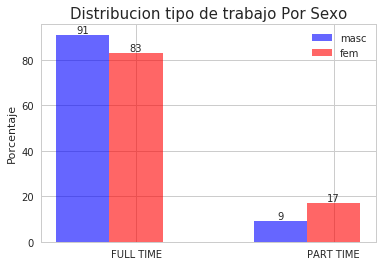

In [22]:
N = 2
ind = np.arange(N)  # la locacion x del grupo
width = 0.27      # el ancho de la barra

fig = plt.figure()
ax = fig.add_subplot(111)

#genero los valores del grafico
mascvals = list(top3_masc_tipo_trabajo["porcentaje"])
rectmasc = ax.bar(ind, mascvals, width, color='b',alpha= 0.6)
femvals = list(top3_fem_tipo_trabajo["porcentaje"])
rectfem = ax.bar(ind+width, femvals, width, color='r',alpha= 0.6)

ax.set_title("Distribucion tipo de trabajo Por Sexo", fontsize=15)
ax.set_ylabel('Porcentaje')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('FULL TIME', 'PART TIME') )
ax.legend( (rectmasc[0], rectfem), ('masc', 'fem') )

#creo la etiquetade los grupos
def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rectmasc)
autolabel(rectfem)

In [23]:
del df_fem_tipo_trabajo
del df_masc_tipo_trabajo
del top3_fem_tipo_trabajo
del top3_masc_tipo_trabajo

# ¿Cómo se distribuye el nivel educativo por sexo?

In [24]:
edu_max_genero= df_edu_unicos_max.merge(id_gen_corto, on= "idpostulante")
edu_masc= edu_max_genero[edu_max_genero["sexo"]== "MASC"].groupby("nombre")["idpostulante",].count()
total= float(edu_masc["idpostulante"].sum())
edu_masc["porcentaje"] = edu_masc["idpostulante"].apply(lambda x: round(x/total*100))
edu_masc=edu_masc.reset_index()
edu_masc["prioridad"]= edu_masc["nombre"].apply(lambda nom: orden_nombre.get(nom))
edu_masc = edu_masc.sort_values(by= "prioridad",ascending= False)
edu_masc

,nombre,idpostulante,porcentaje,prioridad
2,Otro,1672,2,6
4,Secundario,45692,51,5
5,Terciario/Técnico,11981,14,4
6,Universitario,25729,29,3
3,Posgrado,2381,3,2
1,Master,1217,1,1
0,Doctorado,57,0,0


In [25]:
edu_fem= edu_max_genero[edu_max_genero["sexo"]== "FEM"].groupby("nombre")["idpostulante",].count()
total= float(edu_fem["idpostulante"].sum())
edu_fem["porcentaje"] = edu_fem["idpostulante"].apply(lambda x: round(x/total*100))
edu_fem=edu_fem.reset_index()
edu_fem["prioridad"]= edu_fem["nombre"].apply(lambda nom: orden_nombre.get(nom))
edu_fem = edu_fem.sort_values(by= "prioridad",ascending= False)
edu_fem

,nombre,idpostulante,porcentaje,prioridad
2,Otro,2073,2,6
4,Secundario,44763,46,5
5,Terciario/Técnico,15500,16,4
6,Universitario,31445,33,3
3,Posgrado,2136,2,2
1,Master,755,1,1
0,Doctorado,56,0,0


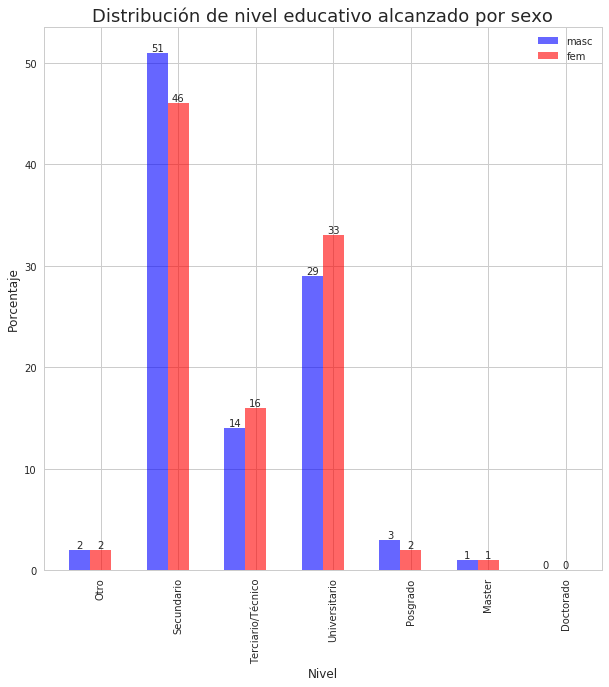

In [26]:
N = 7
ind = np.arange(N)  # la locacion x del grupo
width = 0.27      # el ancho de la barra

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

#genero los valores del grafico
mascvals = list(edu_masc["porcentaje"])
rectmasc = ax.bar(ind, mascvals, width, color='b',alpha= 0.6)
femvals = list(edu_fem["porcentaje"])
rectfem = ax.bar(ind+width, femvals, width, color='r',alpha= 0.6)

ax.set_title("Distribución de nivel educativo alcanzado por sexo", fontsize=18)
ax.set_ylabel('Porcentaje', fontsize=12)
ax.set_xlabel('Nivel', fontsize=12)
ax.set_xticks(ind+width)
ax.set_xticklabels( list(edu_masc["nombre"]))
ax.legend( (rectmasc[0], rectfem), ('masc', 'fem') )

plt.xticks(rotation=90)

#creo la etiquetade los grupos
def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rectmasc)
autolabel(rectfem)

In [27]:
# elimino los dataframes que ya no se van a usar
del edu_fem
del edu_masc
del df_sexo_tipo_trabajo
del id_gen_corto

# ¿Qué areas presentan mayor diferencia de aplicantes por sexo?

In [28]:
df_avisos_postulantes = df_gen_edad.merge(df_postulaciones, on='idpostulante').merge(df_avisos_detalle, on='idaviso')

# tabla cruzada con frecuencia de sexo FEM y MASC
ct = pd.crosstab(df_avisos_postulantes['nombre_area'], df_avisos_postulantes['sexo'])

# columnas para comparar y reordenar
ct['tot'] = ct['FEM'] + ct['MASC']
ct['diff'] = ct['FEM'] - ct['MASC']
ct = ct.sort_values(by='diff', ascending=False)

# tomo los top 10 y preparo para graficar
ct_top_fem_stacked = ct.head(10)[['FEM', 'MASC']].stack().reset_index().rename(columns={0:'count'})

# el iloc[::-1] es para invertirlo dado que estamos tomando los 10 ultimos en forma descendiente
ct_top_masc_stacked = ct.tail(10).iloc[::-1][['FEM', 'MASC']].stack().reset_index().rename(columns={0:'count'})

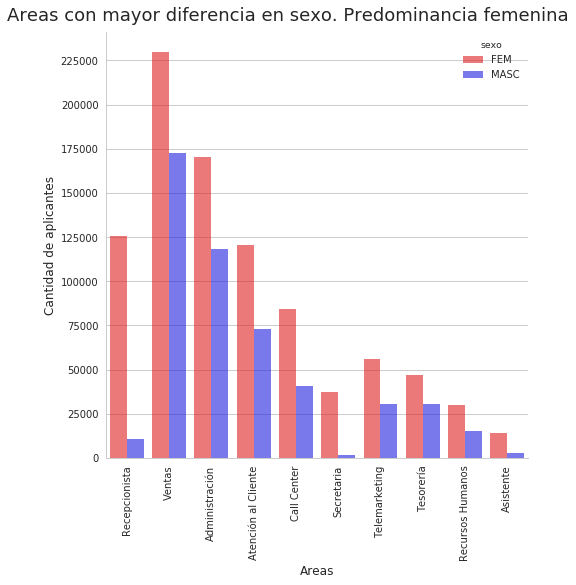

In [29]:
# caso fem
g = sns.factorplot(x='nombre_area', 
                   y='count',
                   data=ct_top_fem_stacked,
                   hue='sexo',
                   palette= {'FEM': 'r', 'MASC': 'b'},
                   errwidth=0.8,
                   kind="bar",
                   legend_out=False,
                   size=7,
                   alpha=0.6)

g.set_xticklabels(rotation=90)

g.set_xlabels("Areas", fontsize=12)
g.set_ylabels("Cantidad de aplicantes", fontsize=12)

yticks = np.arange(0, 250000, 25000)
g.set(yticks=yticks)

plt.subplots_adjust(top=0.93)
g.fig.suptitle('Areas con mayor diferencia en sexo. Predominancia femenina', fontsize=18);

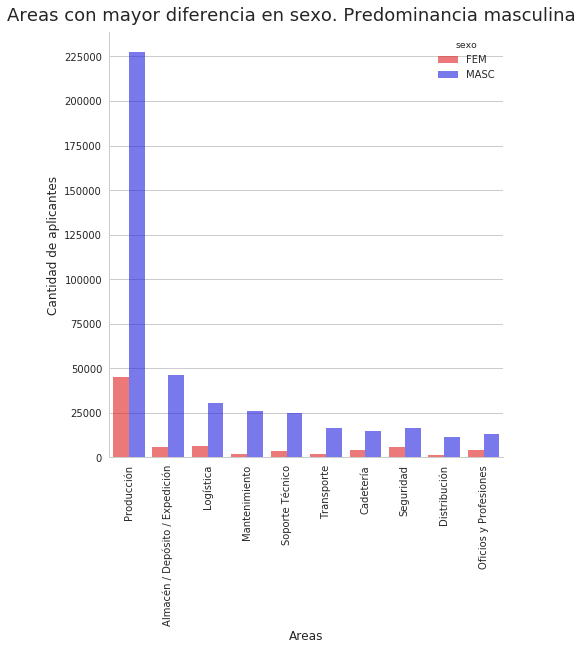

In [30]:
# caso masc
g = sns.factorplot(x='nombre_area', 
                   y='count',
                   data=ct_top_masc_stacked,
                   hue='sexo',
                   palette= {'FEM': 'red', 'MASC': 'blue'},
                   errwidth=0.8,
                   kind="bar",
                   legend_out=False,
                   size=7,
                   alpha=0.6)

g.set_xticklabels(rotation=90)

g.set_xlabels("Areas", fontsize=12)
g.set_ylabels("Cantidad de aplicantes", fontsize=12)

yticks = np.arange(0, 250000, 25000)
g.set(yticks=yticks)

plt.subplots_adjust(top=0.93)
g.fig.suptitle('Areas con mayor diferencia en sexo. Predominancia masculina', fontsize=18);

In [31]:
del ct_top_fem_stacked
del ct_top_masc_stacked
del ct
del df_avisos_postulantes

# ¿En qué horas se registra la mayor cantidad de postulaciones/vistas?

In [32]:
df_vistas["hour"] = df_vistas["timestamp"].dt.hour
df_postulaciones["hour"] = df_postulaciones["fechapostulacion"].dt.hour
df_postulaciones["date"] =df_postulaciones["fechapostulacion"].dt.date

In [33]:
date_ini = datetime.date(year=2018,month=2,day=27)
date_fin = datetime.date(year=2018,month=2,day=28)
df_periodo_postulaciones = df_postulaciones[df_postulaciones["fechapostulacion"].dt.date >= date_ini]
df_periodo_vistas = df_vistas[(df_vistas["timestamp"].dt.date >= date_ini) & (df_vistas["timestamp"].dt.date <= date_fin)]

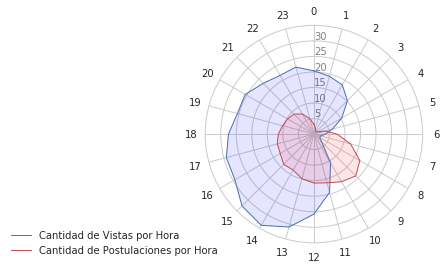

In [34]:
categories = range(0, 24) # 0 a 23 horas

# numero de variables categoricas
N = len(categories)

from math import pi
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Inicializar el grafico
ax = plt.subplot(111, polar=True)
 
# Corremos el inicio para que comienze como un reloj (corro el origen 90°):
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Dibujamos un eje por categoria
plt.xticks(angles[:-1], categories)

# Dibujo labels en y
ax.set_rlabel_position(0)
plt.yticks([5000,10000,15000,20000,25000,30000], ["5","10","15","20","25","30"], color="grey", size=10)
plt.ylim(0,35000)

# Serie de datos para las vistas por hora
values2 = list(df_periodo_vistas.groupby("hour")["idAviso"].count())
values2 += values2[:1]
ax.plot(angles, values2, linewidth=1, linestyle='solid', label="Cantidad de Vistas por Hora")
ax.fill(angles, values2, 'b', alpha=0.1)

# Serie de datos para las postulaciones por hora
values = list(df_periodo_postulaciones.groupby("hour")["idaviso"].count())
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid',color = "C2", label="Cantidad de Postulaciones por Hora")
ax.fill(angles, values, 'r', alpha=0.1)

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1));

In [35]:
del df_periodo_postulaciones
del df_periodo_vistas

# ¿Qué areas y empresas tienen mayor cantidad de postulaciones?

In [36]:
df_posts_avisos = df_avisos_detalle[['idaviso','nombre_area','denominacion_empresa']].merge(df_postulaciones[['idaviso','fechapostulacion','idpostulante']], on='idaviso')
df_posts_avisos['fecha'] = df_posts_avisos['fechapostulacion'].dt.date

In [37]:
def graficar_top_n_postulaciones(N, clave_agrupacion, clave_titulo, x_tick_step=1):
    df_posts_agrupado = df_posts_avisos.groupby(clave_agrupacion)\
                                        .agg({'idpostulante':'count'})\
                                        .rename(columns={'idpostulante': 'count'})

    tot = df_posts_agrupado['count'].sum()

    df_posts_agrupado['perc'] = df_posts_agrupado['count'] * 100.0 / tot
    df_posts_agrupado = df_posts_agrupado.sort_values(by='count', ascending=False)
    df_posts_agrupado = df_posts_agrupado.reset_index()

    df_top_posts = pd.DataFrame(df_posts_agrupado.head(N))

    max_perc = math.ceil(df_top_posts['perc'].max())
    xticks = np.arange(0, max_perc, x_tick_step)

    g = sns.barplot(x=df_top_posts['perc'], y=df_top_posts[clave_agrupacion], orient='h',
                    palette="hls")
    g.set_title("Top {0} de postulaciones por {1}".format(N, clave_titulo.lower()), fontsize=18)
    g.set_xlabel("Postulaciones (%)", fontsize=12)
    g.set_ylabel(clave_titulo, fontsize=12)
    g.set(xticks=xticks);
    
    return g

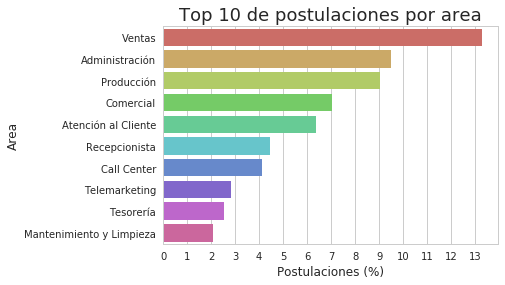

In [38]:
graficar_top_n_postulaciones(10, 'nombre_area', 'Area');

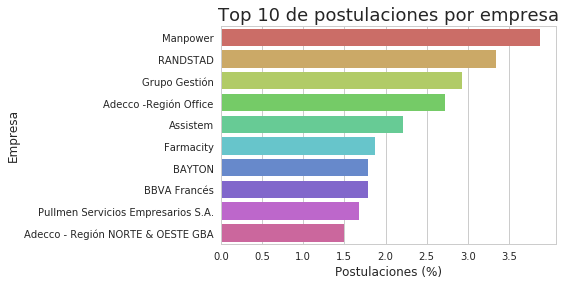

In [39]:
graficar_top_n_postulaciones(10, 'denominacion_empresa', 'Empresa', x_tick_step=0.5);

In [40]:
del df_posts_avisos

# ¿Qué edades hacen mayor uso de la plataforma?

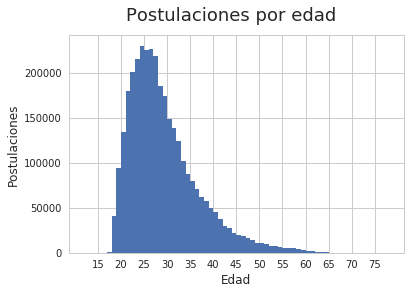

In [41]:
postulaciones_por_edades = df_postulaciones[['idpostulante']].merge(df_gen_edad[['idpostulante', 'edad']], on='idpostulante')

postulaciones_por_edades = postulaciones_por_edades.loc[(0 < postulaciones_por_edades['edad']) & (postulaciones_por_edades['edad'] <= 80)]

min_edad = min(postulaciones_por_edades['edad'])
max_edad = max(postulaciones_por_edades['edad'])

ax = postulaciones_por_edades.hist(bins=(max_edad - min_edad))[0][0]

xticks = np.arange(15, 80, 5)

ax.set_title('')
ax.set_xlabel('Edad', fontsize=12)
ax.set_ylabel('Postulaciones', fontsize=12)
ax.set_xticks(xticks)

fig = ax.get_figure()
fig.suptitle('Postulaciones por edad', fontsize=18);

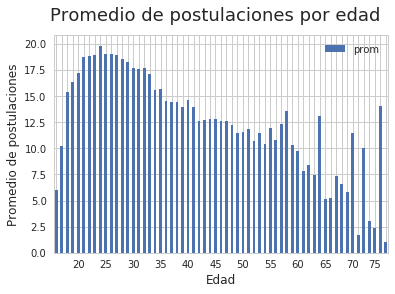

In [42]:
postulaciones_por_edades['aux'] = 1
prom_postulaciones_por_edades = postulaciones_por_edades.groupby(['edad', 'idpostulante'])\
                                                        .count()\
                                                        .reset_index()\
                                                        .groupby('edad')\
                                                        .agg({'aux':'mean'})\
                                                        .reset_index()\
                                                        .rename(columns={'aux':'prom'})
                        
ax = prom_postulaciones_por_edades.set_index('edad').plot.bar()

# oculto labels no multiplos de 5
for t in ax.get_xticklabels():
    if int(t.get_text()) % 5 != 0:
        t.set_visible(False)        

ax.set_title('')
ax.set_xlabel('Edad', fontsize=12)
ax.set_ylabel('Promedio de postulaciones', fontsize=12)

fig = ax.get_figure()
fig.suptitle('Promedio de postulaciones por edad', fontsize=18)

plt.xticks(rotation=0);

In [43]:
df_gen_edad_valida.groupby('edad')\
                  .count()\
                  .rename(columns={'idpostulante':'count'})\
                  .sort_values(by='count')\
                  .loc[lambda x: x['count'] < 100,:]
                
# Las edades más altas tienen en promedio mayor cantidad de postulaciones
# por la baja cantidad de personas en esos grupos

,count,fechanacimiento,sexo
edad,,,
78,1,1,1
74,1,1,1
76,1,1,1
73,2,2,2
71,3,3,3
75,5,5,5
70,7,7,7
69,10,10,10
68,15,15,15


# ¿Cómo se distribuyen las edades para los distintos niveles laborales?

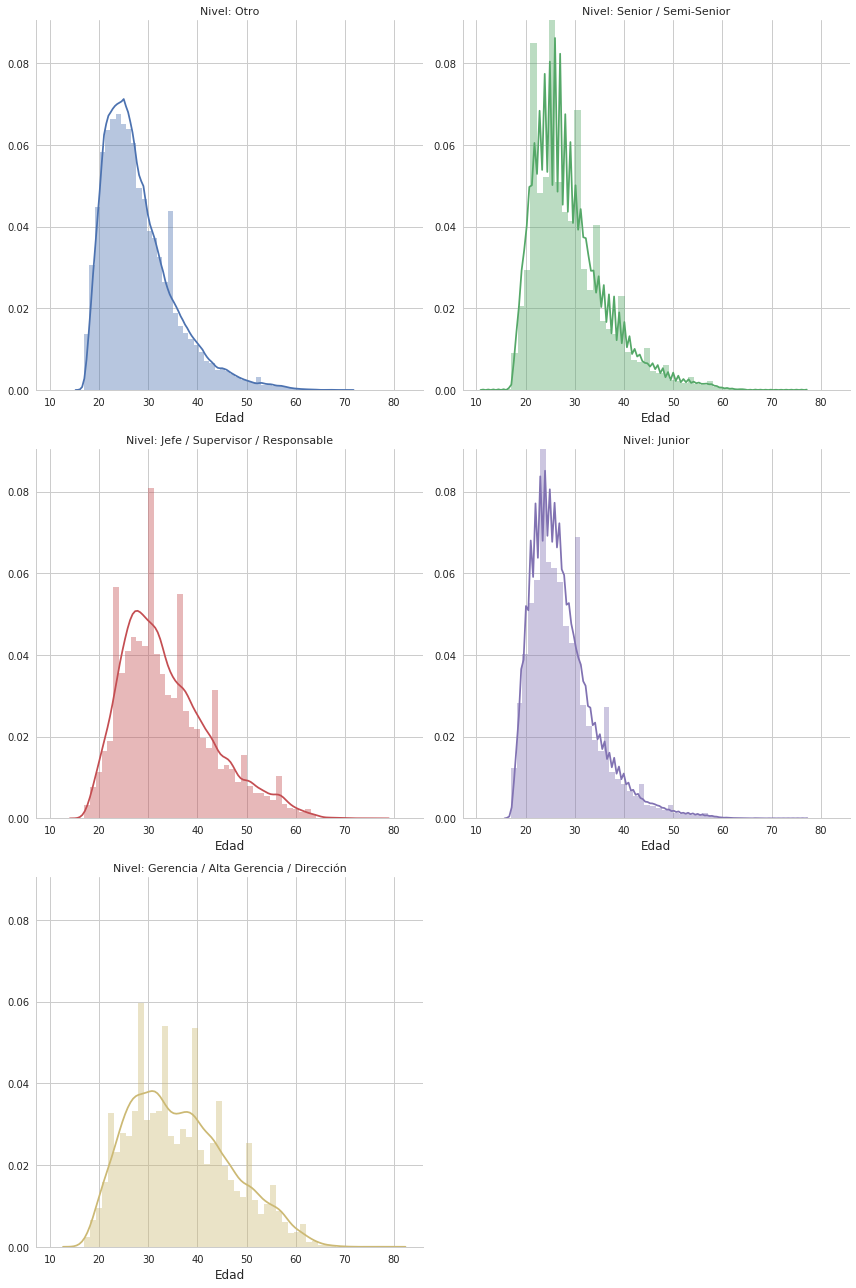

In [44]:
df_postulantes_por_aviso = df_gen_edad[['idpostulante', 'edad']].merge(df_postulaciones[['idpostulante', 'idaviso']], on='idpostulante')\
                                                                .merge(df_avisos_detalle[['idaviso','nivel_laboral']], on='idaviso')

g = sns.FacetGrid(df_postulantes_por_aviso.loc[(0 <= df_postulantes_por_aviso['edad']) & (df_postulantes_por_aviso['edad'] <= 80)], col="nivel_laboral", hue="nivel_laboral", col_wrap=2, size=6)
g.map(sns.distplot, "edad", rug=False)
g.set_titles("Nivel: {col_name}", fontsize=14)

for ax in g.axes.flat:
    plt.setp(ax.get_yticklabels(), visible=True)
    plt.setp(ax.get_xticklabels(), visible=True)
    ax.set_xlabel('Edad', fontsize=12)

plt.tight_layout()

In [45]:
del df_postulantes_por_aviso

Text(0.5,1,'Top 10 areas de avisos')

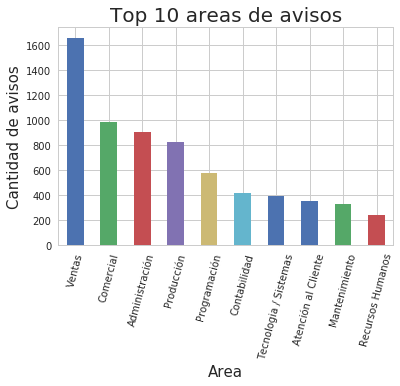

In [46]:
df_avisos_detalle['nombre_area'].value_counts().sort_values(ascending=False)[:10]\
    .plot.bar(rot=75)

plt.xlabel('Area', fontsize=15)
plt.ylabel('Cantidad de avisos', fontsize=15)
plt.title('Top 10 areas de avisos', fontsize=20)